In [ ]:
!pip install Pillow

# Clone the Github Repository

In [ ]:
%cd /content
!git clone https://github.com/kutayozdur/Face-Mask-Detection.git
%cd /content/Face-Mask-Detection/

/content
Cloning into 'Face-Mask-Detection'...
remote: Enumerating objects: 11, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 11 (delta 1), reused 4 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (11/11), 14.52 MiB | 16.20 MiB/s, done.
Resolving deltas: 100% (1/1), done.
/content/Face-Mask-Detection


# Loading the dataset from Kaggle

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("andrewmvd/face-mask-detection")

print("Path to dataset files:", path)

100%|██████████| 398M/398M [00:18<00:00, 22.6MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/andrewmvd/face-mask-detection/versions/1


In [ ]:
import shutil
import os

# Path to the downloaded dataset
source_path = path  # Use the path returned by kagglehub

# Path of GitHub repository folder
repo_path = "/content/Face-Mask-Detection"

# Move the dataset
shutil.move(source_path, os.path.join(repo_path, "dataset"))

print("Dataset moved to:", os.path.join(repo_path, "dataset"))


Dataset moved to: /content/Face-Mask-Detection/dataset


# Exploring the dataset

In [ ]:
import os

dataset_path = "/content/Face-Mask-Detection/dataset"
print(os.listdir(dataset_path))

['images', 'annotations']


In [ ]:
images_dir = os.path.join(dataset_path, "images")

images_list = os.listdir(images_dir)
print(f"Number of images: {len(images_list)}")

# Maybe print the first 5 to see what filenames look like
print("Sample image filenames:", images_list[:5])

Number of images: 853
Sample image filenames: ['maksssksksss597.png', 'maksssksksss339.png', 'maksssksksss146.png', 'maksssksksss752.png', 'maksssksksss66.png']


In [ ]:
annotations_dir = os.path.join(dataset_path, "annotations")
annotations_list = os.listdir(annotations_dir)
print(f"Number of annotations: {len(annotations_list)}")

# Check out a few annotation file names
print("Sample annotation filenames:", annotations_list[:5])

Number of annotations: 853
Sample annotation filenames: ['maksssksksss404.xml', 'maksssksksss791.xml', 'maksssksksss693.xml', 'maksssksksss555.xml', 'maksssksksss171.xml']


In [ ]:
import xml.etree.ElementTree as ET

# Pick one annotation file
sample_annotation = annotations_list[0]
annotation_path = os.path.join(annotations_dir, sample_annotation)

# Parse the XML
tree = ET.parse(annotation_path)
root = tree.getroot()

print(f"Annotation file: {sample_annotation}")
for child in root:
    print(child.tag, child.text)

Annotation file: maksssksksss404.xml
folder images
filename maksssksksss404.png
size 
        
segmented 0
object 
        


In [ ]:
from collections import Counter

labels_count = Counter()

for xml_file in annotations_list:
    xml_path = os.path.join(annotations_dir, xml_file)
    tree = ET.parse(xml_path)
    root = tree.getroot()

    # Each <object> contains a <name> for the class
    for obj in root.findall("object"):
        class_name = obj.find("name").text
        labels_count[class_name] += 1

print("Count of each label:", labels_count)

Count of each label: Counter({'with_mask': 3232, 'without_mask': 717, 'mask_weared_incorrect': 123})


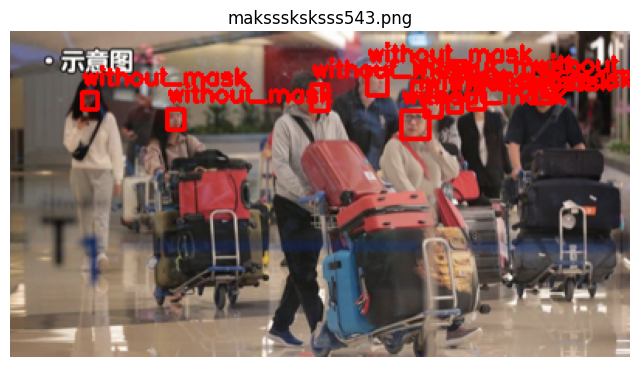

In [ ]:
import random
import cv2
import matplotlib.pyplot as plt

# Pick a random annotation
random_anno = random.choice(annotations_list)
random_anno_path = os.path.join(annotations_dir, random_anno)

# Parse the annotation to get bounding boxes
tree = ET.parse(random_anno_path)
root = tree.getroot()
filename = root.find("filename").text
img_path = os.path.join(images_dir, filename)

# Load the image
img = cv2.imread(img_path)
if img is None:
    print(f"Could not load image: {img_path}")
else:
    # Convert from BGR to RGB for plotting
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Draw the bounding boxes
    for obj in root.findall("object"):
        class_name = obj.find("name").text
        bndbox = obj.find("bndbox")
        xmin = int(bndbox.find("xmin").text)
        ymin = int(bndbox.find("ymin").text)
        xmax = int(bndbox.find("xmax").text)
        ymax = int(bndbox.find("ymax").text)

        # Draw rectangle
        cv2.rectangle(img_rgb, (xmin, ymin), (xmax, ymax), (255, 0, 0), 2)
        cv2.putText(img_rgb, class_name, (xmin, ymin - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

    # Show the image
    plt.figure(figsize=(8, 6))
    plt.imshow(img_rgb)
    plt.title(filename)
    plt.axis('off')
    plt.show()

# Preprocessing the data for SSD training

In [ ]:
import os
import xml.etree.ElementTree as ET

def parse_annotation(annotation_path):
    """
    Parses an annotation XML file to extract relevant data.
    """
    import xml.etree.ElementTree as ET

    tree = ET.parse(annotation_path)
    root = tree.getroot()

    # Extract image filename
    filename = root.find("filename").text

    # Extract image dimensions
    size = root.find("size")
    width = int(size.find("width").text)
    height = int(size.find("height").text)

    # Extract object annotations
    objects = []
    for obj in root.findall("object"):
        class_name = obj.find("name").text
        bndbox = obj.find("bndbox")
        bbox = {
            "xmin": int(bndbox.find("xmin").text),
            "ymin": int(bndbox.find("ymin").text),
            "xmax": int(bndbox.find("xmax").text),
            "ymax": int(bndbox.find("ymax").text),
        }
        objects.append({"class_name": class_name, "bbox": bbox})

    return {
        "filename": filename,
        "width": width,
        "height": height,
        "objects": objects,
    }

# Test parsing one file
sample_parsed = parse_annotation(os.path.join(annotations_dir, annotations_list[0]))
print(sample_parsed)

{'filename': 'maksssksksss404.png', 'width': 301, 'height': 400, 'objects': [{'class_name': 'without_mask', 'bbox': {'xmin': 112, 'ymin': 214, 'xmax': 183, 'ymax': 319}}]}


In [ ]:
class_map = {"with_mask": 1, "without_mask": 2, "mask_weared_incorrect": 3}

# Function to map class names to IDs
def map_class_name_to_id(class_name):
    return class_map[class_name]

In [ ]:
def apply_all_augmentations(image):
    """
    Apply all three augmentations (flip, brightness, contrast) to the input image.

    Parameters:
    - image (numpy.ndarray): Original image.

    Returns:
    - list: List of augmented images with their corresponding metadata.
    """
    augmented_images = []

    # Horizontal Flip
    flipped_image = cv2.flip(image, 1)
    augmented_images.append({"image": flipped_image, "flipped": True, "brightness": False, "contrast": False})

    # Brightness Adjustment
    brightness_image = cv2.convertScaleAbs(image, alpha=1.0, beta=50)  # Increase brightness
    augmented_images.append({"image": brightness_image, "flipped": False, "brightness": True, "contrast": False})

    # Contrast Adjustment
    contrast_image = cv2.convertScaleAbs(image, alpha=1.5, beta=0)  # Increase contrast
    augmented_images.append({"image": contrast_image, "flipped": False, "brightness": False, "contrast": True})

    return augmented_images

In [ ]:
def adjust_bbox_for_flip(bbox, image_width):
    """
    Adjust bounding box for horizontally flipped images.

    Parameters:
    - bbox (list): Original bounding box [xmin, ymin, xmax, ymax].
    - image_width (int): Width of the image.

    Returns:
    - list: Adjusted bounding box [xmin, ymin, xmax, ymax].
    """
    xmin, ymin, xmax, ymax = bbox
    return [image_width - xmax, ymin, image_width - xmin, ymax]

In [ ]:
from copy import deepcopy

def add_augmented_data(dataset, images_dir):
    """
    Add augmented images to the dataset with adjusted bounding boxes.

    Parameters:
    - dataset (list): Original dataset with images, bboxes, and labels.
    - images_dir (str): Directory of the original images.

    Returns:
    - list: Extended dataset with augmented data.
    """
    augmented_dataset = deepcopy(dataset)

    for sample in dataset:
        image_path = os.path.join(images_dir, sample["filename"])
        original_image = cv2.imread(image_path)

        if original_image is None:
            print(f"Could not load image: {image_path}")
            continue

        original_width = original_image.shape[1]
        augmented_images = apply_all_augmentations(original_image)

        for augmented in augmented_images:
            augmented_image = augmented["image"]
            flipped = augmented["flipped"]

            # Adjust bounding boxes if flipped
            adjusted_bboxes = []
            for bbox in sample["bboxes"]:
                if flipped:
                    adjusted_bboxes.append(adjust_bbox_for_flip(bbox, original_width))
                else:
                    adjusted_bboxes.append(bbox)

            # Add augmented sample
            augmented_dataset.append({
                "filename": sample["filename"],  # Optionally rename for clarity
                "image": augmented_image / 255.0,  # Normalize
                "labels": sample["labels"],
                "bboxes": adjusted_bboxes,
                "metadata": {
                    "flipped": flipped,
                    "brightness": augmented["brightness"],
                    "contrast": augmented["contrast"]
                },
            })

    return augmented_dataset

In [ ]:
def preprocess_augmented_dataset(dataset, target_size=(320, 320)):
    """
    Preprocess the augmented dataset: Resize images and adjust bounding boxes.

    Parameters:
    - dataset (list): Augmented dataset with images and metadata.
    - target_size (tuple): Target size for resizing (width, height).

    Returns:
    - list: Preprocessed dataset with resized images and bounding boxes.
    """
    preprocessed_dataset = []

    for sample in dataset:
        image = sample["image"]
        original_height, original_width = image.shape[:2]

        # Resize image
        resized_image = cv2.resize(image, target_size)
        resize_ratio_x = target_size[0] / original_width
        resize_ratio_y = target_size[1] / original_height

        # Adjust bounding boxes for resize
        resized_bboxes = []
        for bbox in sample["bboxes"]:
            xmin, ymin, xmax, ymax = bbox
            resized_bboxes.append([
                int(xmin * resize_ratio_x),
                int(ymin * resize_ratio_y),
                int(xmax * resize_ratio_x),
                int(ymax * resize_ratio_y)
            ])

        # Add preprocessed sample
        preprocessed_dataset.append({
            "image": resized_image / 255.0,  # Normalize
            "labels": sample["labels"],
            "bboxes": resized_bboxes,
            "metadata": sample["metadata"],
        })

    return preprocessed_dataset

In [ ]:
def prepare_dataset(images_dir, annotations_dir):
    """
    Prepares the original dataset by loading images, parsing annotations, and extracting labels and bounding boxes.

    Parameters:
    - images_dir (str): Directory containing the images.
    - annotations_dir (str): Directory containing the annotations.

    Returns:
    - list: Original dataset with images, labels, bounding boxes, and metadata.
    """
    dataset = []

    for xml_file in os.listdir(annotations_dir):
        annotation_path = os.path.join(annotations_dir, xml_file)
        parsed_data = parse_annotation(annotation_path)  # Parse the XML file

        # Get the full image path
        image_path = os.path.join(images_dir, parsed_data["filename"])

        # Load the original image
        original_image = cv2.imread(image_path)
        if original_image is None:
            print(f"Could not load image: {image_path}")
            continue

        # Get original image dimensions
        original_height, original_width = original_image.shape[:2]

        # Extract labels and bounding boxes
        labels = []
        bboxes = []
        for obj in parsed_data["objects"]:
            labels.append(map_class_name_to_id(obj["class_name"]))
            bbox = obj["bbox"]
            bboxes.append([
                int(bbox["xmin"]),
                int(bbox["ymin"]),
                int(bbox["xmax"]),
                int(bbox["ymax"])
            ])

        # Add the original image and its metadata to the dataset
        dataset.append({
            "filename": parsed_data["filename"],
            "image": original_image,  # Keep the raw image for augmentation and preprocessing
            "labels": labels,
            "bboxes": bboxes,
            "metadata": {
                "original_width": original_width,
                "original_height": original_height,
            },
        })

    return dataset

In [ ]:
def validate_and_fix_bboxes(dataset):
    """
    Validates and fixes bounding boxes in the dataset. Ensures all boxes have positive width and height.

    Parameters:
    - dataset (list): List of dataset entries, each containing 'bboxes'.

    Returns:
    - list: Updated dataset with fixed bounding boxes.
    """
    for sample in dataset:
        fixed_bboxes = []
        for bbox in sample["bboxes"]:
            xmin, ymin, xmax, ymax = bbox

            # Check for invalid bounding boxes
            if xmin >= xmax or ymin >= ymax:
                print(f"Invalid box found: {[xmin, ymin, xmax, ymax]}")
                # Slightly increase width and height
                xmax = xmin + 1 if xmax <= xmin else xmax
                ymax = ymin + 1 if ymax <= ymin else ymax
                print(f"Fixed box: {[xmin, ymin, xmax, ymax]}")

            fixed_bboxes.append([xmin, ymin, xmax, ymax])

        # Update the sample with fixed bounding boxes
        sample["bboxes"] = fixed_bboxes

    return dataset

In [ ]:
images_dir = "/content/Face-Mask-Detection/dataset/images"
annotations_dir = "/content/Face-Mask-Detection/dataset/annotations"

# Step 1: Prepare original dataset
dataset = prepare_dataset(images_dir, annotations_dir)

# Step 2: Add augmented data
augmented_dataset = add_augmented_data(dataset, images_dir)

# Step 3: Preprocess augmented dataset
preprocessed_dataset = preprocess_augmented_dataset(augmented_dataset, target_size=(320, 320))

# Step 4: Validate and fix bounding boxes
preprocessed_dataset = validate_and_fix_bboxes(preprocessed_dataset)

print(f"Original dataset size: {len(dataset)}")
print(f"Augmented dataset size: {len(augmented_dataset)}")
print(f"Preprocessed dataset size: {len(preprocessed_dataset)}")

Invalid box found: [184, 51, 184, 54]
Fixed box: [184, 51, 185, 54]
Invalid box found: [184, 51, 184, 54]
Fixed box: [184, 51, 185, 54]
Invalid box found: [184, 51, 184, 54]
Fixed box: [184, 51, 185, 54]
Original dataset size: 853
Augmented dataset size: 3412
Preprocessed dataset size: 3412


In [ ]:
import matplotlib.pyplot as plt
import random
import cv2

# Shuffle the dataset and pick 20 random samples
random_samples = random.sample(augmented_dataset, min(len(augmented_dataset), 20))

# Visualize the samples
for sample in random_samples:
    image = (sample["image"] * 255).astype("uint8")  # De-normalize for display
    bboxes = sample["bboxes"]

    # Draw bounding boxes
    for bbox in bboxes:
        xmin, ymin, xmax, ymax = bbox
        cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (255, 0, 0), 2)  # Red boxes for visualization

    plt.figure(figsize=(8, 6))
    plt.imshow(image)
    plt.axis("off")
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
from sklearn.model_selection import train_test_split

train_data, val_test_data = train_test_split(preprocessed_dataset, test_size=0.2, random_state=42)
val_data, test_data = train_test_split(val_test_data, test_size=0.5, random_state=42)

print(f"Train: {len(train_data)}, Validation: {len(val_data)}, Test: {len(test_data)}")

Train: 2729, Validation: 341, Test: 342


In [ ]:
def data_generator(data, batch_size):
    for i in range(0, len(data), batch_size):
        batch = data[i:i+batch_size]
        images = np.array([item["image"] for item in batch])
        labels = [item["labels"] for item in batch]
        bboxes = [item["bboxes"] for item in batch]
        yield images, labels, bboxes

# Training SSD-MobileNet

In [ ]:
import torchvision
from torchvision.models.detection import ssdlite320_mobilenet_v3_large
from torchvision.models.detection.anchor_utils import AnchorGenerator

# Load pre-trained SSD-MobileNet model
model = ssdlite320_mobilenet_v3_large(pretrained=True)

# Replace the classification head to match your dataset (3 classes + 1 background class)
num_classes = 3 + 1  # Add 1 for the background
model.head.classification_head.num_classes = num_classes

model = model.to("cuda")

print(model)

SSD(
  (backbone): SSDLiteFeatureExtractorMobileNet(
    (features): Sequential(
      (0): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (2): Hardswish()
        )
        (1): InvertedResidual(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
              (1): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
              (2): ReLU(inplace=True)
            )
            (1): Conv2dNormActivation(
              (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (1): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
            )
          )
        )
        (2): Invert

In [ ]:
# SSD comes with a built-in loss calculation
from torch.optim import Adam
import torch.optim as optim

# Define the optimizer with weight decay
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)

# Optionally define your custom loss function (if needed)
def ssd_loss(predictions, targets):
    classification_loss = ...  # Cross-entropy
    localization_loss = ...  # Smooth L1 loss
    return classification_loss + localization_loss

In [ ]:
import torch

def custom_collate_fn(batch):
    """
    Custom collate function for handling variable-sized labels and bounding boxes in object detection datasets.

    Args:
        batch (list): A list of dataset samples, where each sample is a dictionary with keys:
                      - "image": Preprocessed image (numpy array).
                      - "labels": List of labels.
                      - "bboxes": List of bounding boxes.

    Returns:
        tuple: A tuple containing:
               - images: Tensor of batched images.
               - targets: List of dictionaries with keys "boxes" and "labels".
    """
    images = []
    targets = []

    for sample in batch:
        # Convert numpy image to PyTorch tensor
        images.append(torch.from_numpy(sample["image"]).permute(2, 0, 1))  # Convert HWC to CHW

        # Prepare labels and bounding boxes
        targets.append({
            "boxes": torch.tensor(sample["bboxes"], dtype=torch.float32),
            "labels": torch.tensor(sample["labels"], dtype=torch.int64)
        })

    return torch.stack(images, dim=0), targets

In [ ]:
from torch.utils.data import DataLoader
import torch

# Create DataLoader
batch_size = 32
train_loader = DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=custom_collate_fn
)

val_loader = DataLoader(
    val_data,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=custom_collate_fn
)

# Training loop with early stopping
num_epochs = 100
train_losses = []
val_losses = []
patience = 5  # Number of epochs to wait for improvement before stopping
best_val_loss = float('inf')
early_stop_counter = 0

for epoch in range(num_epochs):
    # Training Phase
    model.train()
    train_loss = 0

    for images, targets in train_loader:
        # Convert images to float32 and move to GPU
        images = [img.to("cuda", dtype=torch.float32) for img in images]

        # Move targets (boxes and labels) to GPU
        targets = [
            {
                "boxes": target["boxes"].to("cuda", dtype=torch.float32),
                "labels": target["labels"].to("cuda", dtype=torch.int64)
            }
            for target in targets
        ]

        # Forward pass
        loss_dict = model(images, targets)

        # Sum all loss components
        losses = sum(loss_dict.values())

        # Backward pass
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        train_loss += losses.item()

    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation Phase
    model.train()  # Temporarily set model to training mode to compute loss
    val_loss = 0

    with torch.no_grad():  # Disable gradient computation
        for images, targets in val_loader:
            # Convert images to float32 and move to GPU
            images = [img.to("cuda", dtype=torch.float32) for img in images]

            # Move targets (boxes and labels) to GPU
            targets = [
                {
                    "boxes": target["boxes"].to("cuda", dtype=torch.float32),
                    "labels": target["labels"].to("cuda", dtype=torch.int64)
                }
                for target in targets
            ]

            # Forward pass to compute loss
            loss_dict = model(images, targets)  # Should now return a loss dictionary

            # Sum all loss components
            total_loss = sum(loss_dict.values())
            val_loss += total_loss.item()

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    # Print epoch summary
    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    # Early Stopping Logic
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        early_stop_counter = 0  # Reset the counter if validation loss improves
    else:
        early_stop_counter += 1
        print(f"Validation loss did not improve for {early_stop_counter} epochs.")
        if early_stop_counter >= patience:
            print("Early stopping triggered. Training stopped.")
            break

Epoch [1/100] - Train Loss: 5.3209, Val Loss: 3.6608
Epoch [2/100] - Train Loss: 3.3445, Val Loss: 3.1012
Epoch [3/100] - Train Loss: 2.9279, Val Loss: 2.8580
Epoch [4/100] - Train Loss: 2.6824, Val Loss: 2.7020
Epoch [5/100] - Train Loss: 2.5481, Val Loss: 2.6188
Epoch [6/100] - Train Loss: 2.3894, Val Loss: 2.4952
Epoch [7/100] - Train Loss: 2.3108, Val Loss: 2.4190
Epoch [8/100] - Train Loss: 2.2049, Val Loss: 2.3696
Epoch [9/100] - Train Loss: 2.1326, Val Loss: 2.3040
Epoch [10/100] - Train Loss: 2.0761, Val Loss: 2.2675
Epoch [11/100] - Train Loss: 2.0140, Val Loss: 2.2201
Epoch [12/100] - Train Loss: 1.9740, Val Loss: 2.1852
Epoch [13/100] - Train Loss: 1.9094, Val Loss: 2.1493
Epoch [14/100] - Train Loss: 1.8846, Val Loss: 2.1308
Epoch [15/100] - Train Loss: 1.8399, Val Loss: 2.0978
Epoch [16/100] - Train Loss: 1.7915, Val Loss: 2.0752
Epoch [17/100] - Train Loss: 1.7370, Val Loss: 2.0547
Epoch [18/100] - Train Loss: 1.7307, Val Loss: 2.0436
Epoch [19/100] - Train Loss: 1.6928, 

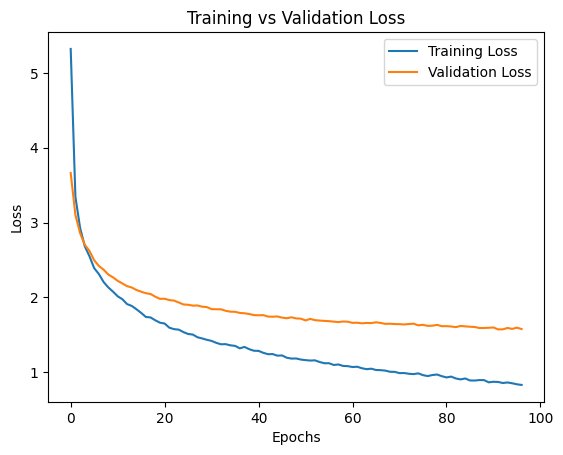

In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Validation Loss')
plt.show()

In [ ]:
# Save the trained model weights
torch.save(model.state_dict(), "ssd_mobilenet_trained.pth")

In [ ]:
# Check if the directory exists, and create it if it doesn't
!mkdir -p /content/Face-Mask-Detection/models

# Move the file
!mv ssd_mobilenet_trained.pth /content/Face-Mask-Detection/models/

In [ ]:
torch.save(optimizer.state_dict(), "ssd_optimizer_state.pth")

In [ ]:
# Check if the directory exists, and create it if it doesn't
!mkdir -p /content/Face-Mask-Detection/models

# Move the file
!mv ssd_optimizer_state.pth /content/Face-Mask-Detection/models/

# Testing the trained SSD model

In [ ]:
# Create DataLoader for test dataset
test_loader = DataLoader(
    test_data,
    batch_size=1,  # Evaluate one image at a time
    shuffle=False,  # No shuffling for evaluation
    collate_fn=custom_collate_fn
)

In [ ]:
def compute_iou(pred_box, gt_box):
    """
    Compute the Intersection over Union (IoU) between a predicted box and a ground truth box.

    Parameters:
    - pred_box (list or array): [xmin, ymin, xmax, ymax] for predicted box.
    - gt_box (list or array): [xmin, ymin, xmax, ymax] for ground truth box.

    Returns:
    - float: IoU value.
    """
    # Calculate intersection
    xA = max(pred_box[0], gt_box[0])
    yA = max(pred_box[1], gt_box[1])
    xB = min(pred_box[2], gt_box[2])
    yB = min(pred_box[3], gt_box[3])
    inter_width = max(0, xB - xA)
    inter_height = max(0, yB - yA)
    inter_area = inter_width * inter_height

    # Calculate union
    pred_area = max(0, pred_box[2] - pred_box[0]) * max(0, pred_box[3] - pred_box[1])
    gt_area = max(0, gt_box[2] - gt_box[0]) * max(0, gt_box[3] - gt_box[1])
    union_area = pred_area + gt_area - inter_area

    # Avoid division by zero
    if union_area == 0:
        return 0.0
    return inter_area / union_area

In [ ]:
def evaluate_model(model, data_loader, confidence_threshold=0.4, iou_threshold=0.5):
    """
    Evaluate the model on the test dataset with precision, recall, and IoU metrics.

    Parameters:
    - model: The trained object detection model.
    - data_loader: DataLoader for the test dataset.
    - confidence_threshold (float): Minimum confidence for a prediction to be considered.
    - iou_threshold (float): IoU threshold for considering a prediction as correct.

    Returns:
    - tuple: precision, recall, avg_iou
    """
    model.eval()  # Set the model to evaluation mode
    true_positives = 0
    false_positives = 0
    false_negatives = 0
    total_iou = 0
    num_matches = 0

    with torch.no_grad():  # Disable gradient calculations for evaluation
        for images, targets in data_loader:
            # Ensure images are in float32 and move them to the appropriate device
            images = [img.to("cuda", dtype=torch.float32) for img in images]

            # Perform inference
            outputs = model(images)

            for output, target in zip(outputs, targets):
                # Apply confidence threshold
                keep_indices = output['scores'] > confidence_threshold
                pred_boxes = output['boxes'][keep_indices].cpu().numpy()
                pred_scores = output['scores'][keep_indices].cpu().numpy()
                pred_labels = output['labels'][keep_indices].cpu().numpy()

                gt_boxes = target["boxes"].cpu().numpy()
                gt_labels = target["labels"].cpu().numpy()

                # Match predicted boxes with ground truth boxes
                matched_gt = set()
                for pred_box, pred_label in zip(pred_boxes, pred_labels):
                    best_iou = 0
                    best_gt_idx = -1
                    for gt_idx, (gt_box, gt_label) in enumerate(zip(gt_boxes, gt_labels)):
                        if gt_idx in matched_gt or pred_label != gt_label:
                            continue
                        iou = compute_iou(pred_box, gt_box)
                        if iou > best_iou:
                            best_iou = iou
                            best_gt_idx = gt_idx

                    if best_iou >= iou_threshold:
                        true_positives += 1
                        matched_gt.add(best_gt_idx)
                        total_iou += best_iou
                        num_matches += 1
                    else:
                        false_positives += 1

                # Remaining unmatched ground truth boxes are false negatives
                false_negatives += len(gt_boxes) - len(matched_gt)

    # Calculate precision, recall, and average IoU
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0.0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0.0
    avg_iou = total_iou / num_matches if num_matches > 0 else 0.0

    return precision, recall, avg_iou

In [ ]:
# Run evaluation
precision, recall, avg_iou = evaluate_model(model, test_loader)

# Print results
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Average IoU: {avg_iou:.4f}")

Precision: 0.8166
Recall: 0.1382
Average IoU: 0.8007


# Testing the model with my own photos

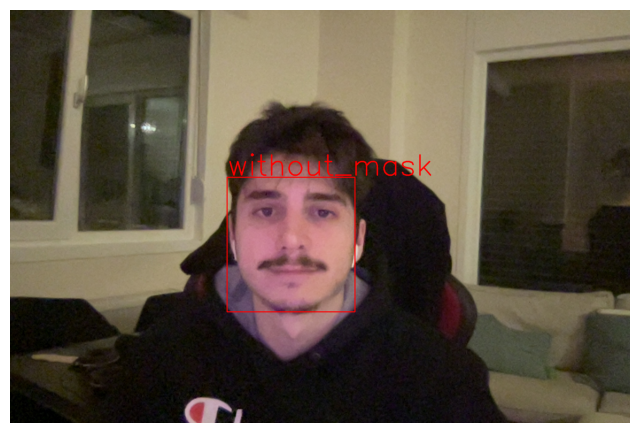

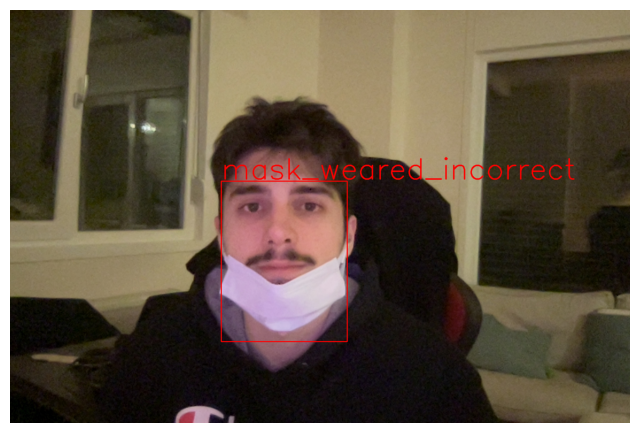

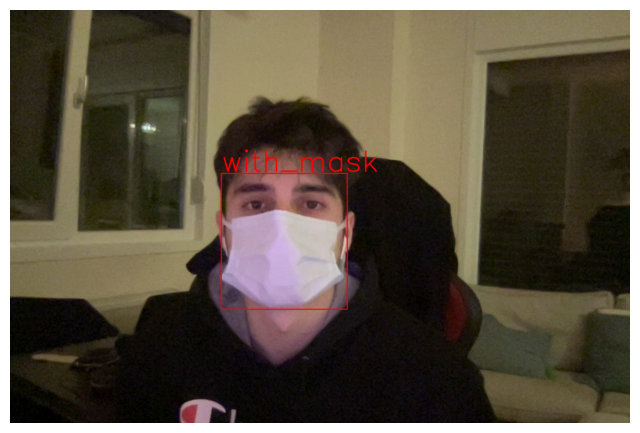

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt
import torch

# Class label mapping
class_mapping = {1: "with_mask", 2: "without_mask", 3: "mask_weared_incorrect"}

def preprocess_and_test_images(model, image_folder, target_size=(320, 320), confidence_threshold=0.5):
    """
    Preprocess and test the model on images.

    Parameters:
    - model: Trained object detection model.
    - image_folder (str): Directory containing images.
    - target_size (tuple): Target size for resizing (width, height).
    - confidence_threshold (float): Confidence threshold for predictions.

    Returns:
    - None: Displays the predictions on the images.
    """
    model.eval()  # Set model to evaluation mode
    images = [os.path.join(image_folder, img) for img in os.listdir(image_folder)]

    for image_path in images:
        # Load the image
        image = cv2.imread(image_path)
        original_height, original_width = image.shape[:2]

        # Resize image for preprocessing
        resized_image = cv2.resize(image, target_size)
        resize_ratio_x = target_size[0] / original_width
        resize_ratio_y = target_size[1] / original_height

        # Normalize the image
        image_tensor = torch.tensor(resized_image / 255.0, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).to("cuda")

        # Perform inference
        with torch.no_grad():
            outputs = model(image_tensor)

        # Extract predictions
        output = outputs[0]
        boxes = output["boxes"].cpu().numpy()
        scores = output["scores"].cpu().numpy()
        labels = output["labels"].cpu().numpy()

        # Visualize the predictions
        for box, score, label in zip(boxes, scores, labels):
            if score > confidence_threshold:  # Apply confidence threshold
                xmin, ymin, xmax, ymax = map(int, box)
                xmin = int(xmin / resize_ratio_x)
                ymin = int(ymin / resize_ratio_y)
                xmax = int(xmax / resize_ratio_x)
                ymax = int(ymax / resize_ratio_y)

                label_text = class_mapping.get(label, "unknown")
                cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (0, 0, 255), 3)  # Red color, thickness 3
                cv2.putText(
                    image,
                    label_text,
                    (xmin, ymin - 10),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    4.5,  # Tripled font size
                    (0, 0, 255),  # Red color for text
                    6  # Increased thickness of text
                )

        # Show the image with predictions
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(8, 6))
        plt.imshow(image_rgb)
        plt.axis("off")
        plt.show()

# Specify the folder with your images
image_folder = "/content/Face-Mask-Detection/my_images"

# Preprocess and test images
preprocess_and_test_images(model, image_folder)